In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


## epochs = 100
## epsilon_std = 1.0

In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 100
epsilon_std = 1.0

In [4]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [9]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [10]:
#y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, x_decoded_mean)
vae.compile(loss=vae_loss, optimizer='rmsprop')

In [11]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [13]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960                                       
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514                                          
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 2)              514                                          
___________________________________________________________________________________________

In [14]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s - loss: 190.1082 - val_loss: 171.7106
Epoch 2/100
60000/60000 [==============================] - 10s - loss: 169.2161 - val_loss: 168.1545
Epoch 3/100
60000/60000 [==============================] - 13s - loss: 166.3629 - val_loss: 165.4113
Epoch 4/100
60000/60000 [==============================] - 13s - loss: 164.2477 - val_loss: 163.7047
Epoch 5/100
60000/60000 [==============================] - 17s - loss: 162.6566 - val_loss: 162.1406
Epoch 6/100
60000/60000 [==============================] - 16s - loss: 161.3705 - val_loss: 161.3929
Epoch 7/100
60000/60000 [==============================] - 21s - loss: 160.1779 - val_loss: 159.9361
Epoch 8/100
60000/60000 [==============================] - 23s - loss: 159.0887 - val_loss: 159.0712
Epoch 9/100
60000/60000 [==============================] - 26s - loss: 158.1119 - val_loss: 158.2367
Epoch 10/100
60000/60000 [===============

In [15]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

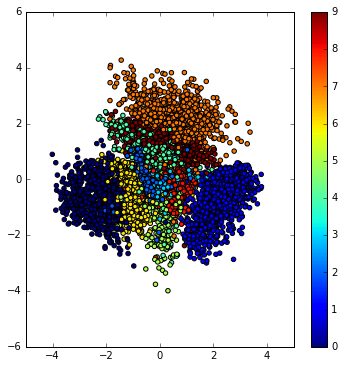

In [16]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [25]:
temp_x_0=[]
temp_x_1=[]
temp_y=[]
for i in range(10000):
    if y_test[i] == 7:
        temp_x_0.append(x_test_encoded[i, 0])
        temp_x_1.append(x_test_encoded[i, 1])
        temp_y.append(y_test[i])
    elif y_test[i] == 9:
        temp_x_0.append(x_test_encoded[i, 0])
        temp_x_1.append(x_test_encoded[i, 1])
        temp_y.append(y_test[i])
temp_x_0=np.array(temp_x_0)
temp_x_1=np.array(temp_x_1)
temp_y=np.array(temp_y)

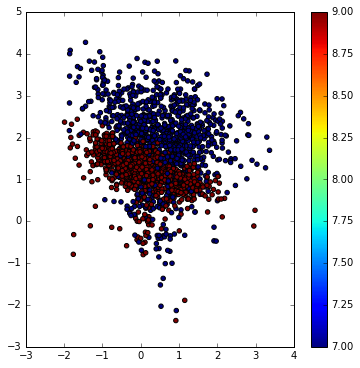

In [26]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(temp_x_0, temp_x_1, c=temp_y, cmap= 'jet')
plt.colorbar()
plt.show()

In [17]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [18]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [19]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

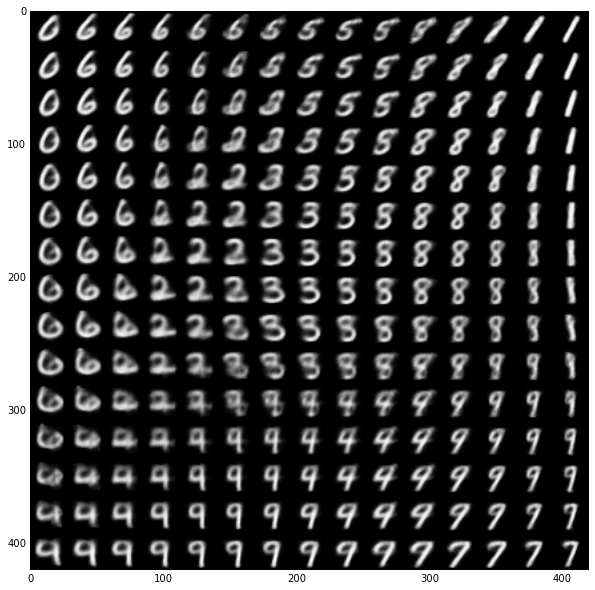

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

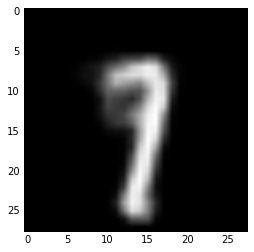

In [29]:
#9
z_sample = np.array([[2, 1]])
x_decoded = generator.predict(z_sample)
plt.imshow(x_decoded.reshape(28,28), cmap='Greys_r')

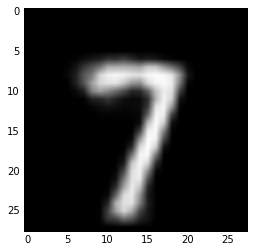

In [30]:
#7
z_sample = np.array([[2, 2]])
x_decoded = generator.predict(z_sample)
plt.imshow(x_decoded.reshape(28,28), cmap='Greys_r')

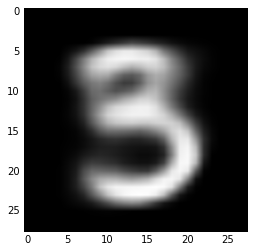

In [23]:
z_sample = np.array([[0, 0]])
x_decoded = generator.predict(z_sample)
plt.imshow(x_decoded.reshape(28,28), cmap='Greys_r')

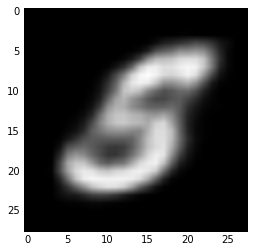

In [24]:
z_sample = np.array([[0, -1]])
x_decoded = generator.predict(z_sample)
plt.imshow(x_decoded.reshape(28,28), cmap='Greys_r')